# by Magomedov Rustam
#### P.S. - I combined the report and w10 notebook in one for simplicity

In [1]:
import bs4
from bs4 import BeautifulSoup
import requests
import regex as re
import csv
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import networkx as nx
import os

In [2]:
%matplotlib inline

plt.style.use('seaborn-whitegrid')

# Parameters & variables

In [3]:
# actors from the github repo
actors_links = {
    'Adam Sandler' : 'https://www.imdb.com/name/nm0001191/fullcredits',
    'Akshay Kumar' : 'https://www.imdb.com/name/nm0474774/fullcredits',
    'Bradley Cooper' : 'https://www.imdb.com/name/nm0177896/fullcredits',
    'Chris Evans' : 'https://www.imdb.com/name/nm0262635/fullcredits',
    'Chris Hemsworth': 'https://www.imdb.com/name/nm1165110/fullcredits',
    'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005/fullcredits',
    'Jackie Chan' : 'https://www.imdb.com/name/nm0000329/fullcredits',
    'Robert Downey Jr.': 'https://www.imdb.com/name/nm0000375/fullcredits',
    'Scarlett Johansson' : 'https://www.imdb.com/name/nm0424060/fullcredits',
    'Sofia Vergara' : 'https://www.imdb.com/name/nm0005527/fullcredits'
}

# Movies by actor

In [4]:
def filmo_category_section_finder(soup):
    item_length = len(soup.find_all(class_='filmo-category-section'))
    it = 0

    for i in range(item_length):
        actor_finder = soup.find_all(class_='filmo-category-section')[i]
        for el in actor_finder.select('div'):
            if el.get('id') is not None:
                if el.get('id').split('-')[0] in ('actor', 'actress'):
                    it = i
    return it

In [5]:
def get_actor_name(url):
    """
    This function takes a url to a movie page and returns the title of the page - which is Actor's name. Helper function for validation
    params: url - url to a movie page
    returns: title - title of the movie
    """
    user_agent = {'User-agent': 'Mozilla 5.0'}
    fc = '/fullcredits'
    if fc in url:
        url = re.sub(fc, '', url)
    response = requests.get(url, headers=user_agent)
    title = re.search(r'<title>(.*) - IMDb</title>', response.text).group(1)
    return title

In [6]:
def get_movies_by_actor_soup(actor_page_soup:BeautifulSoup(), num_of_movies_limit=None) -> list():
    """
    This functions takes a beautifulsoup soup object (actor_page_soup) of the actors page and returns a list of all movies that the actor played in.
    params:
        actor_page_soup: soup object of the actors fullcredits page on IMDB
        num_of_movies_limit: int, optional, default=None, limit the number of movies returned
    returns:
        films_and_links: list of tuples (name_of_movie, url_to_movie_page)
    """
    # find all instances where the person was an actor
    index = filmo_category_section_finder(actor_page_soup)
    is_actor = actor_page_soup.find_all('div', class_='filmo-category-section')[index]

    # find all movies
    content = is_actor.find_all('div', class_ = 'filmo-row')

    # find all movies that have already been released - a safe check
    movies_w_year = [i for i in content if i.find('span', class_= 'year_column').text.strip() not in ['????', '']]

    # remove unreleased
    released_movies = [i for i in movies_w_year if i.find('a', attrs={'class': 'in_production'}) is None]

    # list of content types to exclude
    exclude_list = ['(TV Series)', '(Short)', '(Video Game)', '(Video documentary)', '(Video documentary short)', '(Video short)', '(Video)', '(TV Movie)', '(TV Mini Series)', '(TV Mini-Series)', '(TV Series short)', '(TV Series documentary)', '(TV Special)', '(Music Video)', '(Music Video short)', '(voice)']

    # filter the item out if it contains content other than film
    movies = [i for i in released_movies if i.contents[4].strip() not in exclude_list]

    # filter out voice overs
    movies_wo_voiceovers = [i for i in movies if exclude_list[-1] not in i.text.strip()]

    # create a tuple of format (film_name, film_url)
    films_and_links = [(i.contents[3].text.strip(), 'https://www.imdb.com' + i.find('a').attrs['href']) for i in movies_wo_voiceovers]
    films_and_links = [(i[0], re.sub(r'\?.*', 'fullcredits', i[1])) for i in films_and_links]

    
    # limit condition
    if num_of_movies_limit is not None:
        return films_and_links[:num_of_movies_limit]

    return films_and_links

In [7]:
def prep_actor_soup(url:str) -> BeautifulSoup():
    """
    This function takes a url to a movie page and returns a beautifulsoup soup object of the fullcredits page.
    params: url - url to a movie page
    return: soup - beautifulsoup soup object of the fullcredits page
    """
    user_agent = {'User-agent': 'Mozilla 5.0'}
    fc = '/fullcredits'
    
    if fc in url:
        response = requests.get(url, headers=user_agent)
    else:
        response = requests.get(url+fc, headers=user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

# Actors by movie

In [8]:
def prep_cast_page_soup(url) -> BeautifulSoup():
    """
    This function takes a url to a movie page and returns a beautifulsoup soup object of the fullcredits page.
    params: url - url to a movie page
    returns: soup - beautifulsoup soup object of the fullcredits page
    """
    user_agent = {'User-agent': 'Mozilla 5.0'}
    response = requests.get(url, headers=user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [9]:
def get_actors_by_movie_soup(cast_page_soup:BeautifulSoup(), num_of_actors_limit=None) -> list():
    """
    This function takes a beautifulsoup soup object (cast_page_soup) of a page for the cast & crew for the current film.
    params:
        cast_page_soup: soup object of a page for the cast & crew for the current film
        num_of_actors_limit: int, optional, default=None
    return:
        actors: list of tuples (name_of_actor, url_to_actor_page)
    """
    cast_table = cast_page_soup.find_all('table', class_ = 'cast_list')
    actors = [(i.text.strip(), 'https://www.imdb.com' + i.find('a')['href']) for i in cast_table[0].find_all('td', attrs={'class' : None})]
    match = re.compile(r'\?.*')
    actors = [(i[0], re.sub(match, 'fullcredits', i[1])) for i in actors]
    
    if num_of_actors_limit is not None:
        actors = actors[:num_of_actors_limit]
    return actors

# Testing functions

In [10]:
# testing that the function works with specified limits, limits that exceed the number of records, and no limits
limits = [5, 1000, None]

In [11]:
# testing get_actors_by_movie_soup func
test_url = 'https://www.imdb.com/name/nm0425005' #The Rock

for limit in limits:
    print(f'Limit: {limit}', *get_movies_by_actor_soup(prep_actor_soup(test_url), limit), sep='\n', end='\n\n')

Limit: 5
('Fast X', 'https://www.imdb.com/title/tt5433140/fullcredits')
('Black Adam', 'https://www.imdb.com/title/tt6443346/fullcredits')
('Red Notice', 'https://www.imdb.com/title/tt7991608/fullcredits')
('Jungle Cruise', 'https://www.imdb.com/title/tt0870154/fullcredits')
('Jumanji: The Next Level', 'https://www.imdb.com/title/tt7975244/fullcredits')

Limit: 1000
('Fast X', 'https://www.imdb.com/title/tt5433140/fullcredits')
('Black Adam', 'https://www.imdb.com/title/tt6443346/fullcredits')
('Red Notice', 'https://www.imdb.com/title/tt7991608/fullcredits')
('Jungle Cruise', 'https://www.imdb.com/title/tt0870154/fullcredits')
('Jumanji: The Next Level', 'https://www.imdb.com/title/tt7975244/fullcredits')
('Fast & Furious Presents: Hobbs & Shaw', 'https://www.imdb.com/title/tt6806448/fullcredits')
('Fighting with My Family', 'https://www.imdb.com/title/tt6513120/fullcredits')
('Skyscraper', 'https://www.imdb.com/title/tt5758778/fullcredits')
('Rampage: Big Meets Bigger', 'https://www.

In [12]:
# testing the actors by movies
test_url = 'https://www.imdb.com/title/tt3480822/fullcredits/'  #Black Widow

for limit in limits:
    print(f'Limit: {limit}', *get_actors_by_movie_soup(prep_cast_page_soup(test_url), limit), sep='\n', end='\n\n')

Limit: 5
('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/fullcredits')
('Florence Pugh', 'https://www.imdb.com/name/nm6073955/fullcredits')
('Rachel Weisz', 'https://www.imdb.com/name/nm0001838/fullcredits')
('David Harbour', 'https://www.imdb.com/name/nm1092086/fullcredits')
('Ray Winstone', 'https://www.imdb.com/name/nm0935653/fullcredits')

Limit: 1000
('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/fullcredits')
('Florence Pugh', 'https://www.imdb.com/name/nm6073955/fullcredits')
('Rachel Weisz', 'https://www.imdb.com/name/nm0001838/fullcredits')
('David Harbour', 'https://www.imdb.com/name/nm1092086/fullcredits')
('Ray Winstone', 'https://www.imdb.com/name/nm0935653/fullcredits')
('Ever Anderson', 'https://www.imdb.com/name/nm8349839/fullcredits')
('Violet McGraw', 'https://www.imdb.com/name/nm8627157/fullcredits')
('O-T Fagbenle', 'https://www.imdb.com/name/nm1282966/fullcredits')
('William Hurt', 'https://www.imdb.com/name/nm0000458/fullcredits')
('Olga K

# Distances

In [4]:
limit = 5

In [5]:
def get_movie_distance(actor_start_url:str, actor_end_url:str, num_of_actors_limit=None, num_of_movies_limit=None) -> int:
    """
    This function takes two urls to actors pages and returns the movie distance between them.
    params:
        actor_start_url: url to the first actor page
        actor_end_url: url to the second actor page
        num_of_actors_limit: int, optional, default=None, limit the number of actors returned
        num_of_movies_limit: int, optional, default=None, limit the number of movies returned
    returns:
        movie_distance: int, the movie distance between the two actors when the distance is less or equal to 3, else -1
    """
    if not actor_start_url.startswith('https://www.'):
        actor_start_url = 'https://www.' + actor_start_url
    if not actor_end_url.startswith('https://www.'):
        actor_end_url = 'https://www.' + actor_end_url

    # init basic params for the search, increment distance
    curr_dist = 1
    movies_seen = set()
    actors_seen = set(actor_start_url)
    actors_to_check = [actor_start_url]

    while curr_dist <= 3: 
        tb_explored = []
        print(f'Iteration: {curr_dist}. Actors to check: {len(actors_to_check)}')

        # iterate over actors, parse movies by actor
        for actor_url in actors_to_check:
            movies = get_movies_by_actor_soup(prep_actor_soup(actor_url), num_of_movies_limit)
            movies = [m for m in movies if m[1] not in movies_seen]  #filtering out movies that have already been parsed

            # iterate over movies
            for movie in movies:
                title, link = movie
                movies_seen.add(link)  #cache movies 
                
                try:
                    actors = get_actors_by_movie_soup(prep_cast_page_soup(link), num_of_actors_limit)
                except:
                    continue
                
                #filtering out actors that have already been seen
                actors = [a for a in actors if a[1] not in actors_seen] 

                for _, actor_url in actors:
                    if actor_url == actor_end_url:
                        return curr_dist
                    
                    if actor_url not in actors_seen:
                        tb_explored.append(actor_url) 
        
        actors_seen.update(actors_to_check)
        actors_to_check = tb_explored
        curr_dist += 1
    return -1

In [6]:
def save_distances(path: str, actors_links: dict) -> None:
    """
    This function takes a path to a csv file and a dictionary of actors and saves the movie distance between each pair of actors in the dictionary to the csv file.
    params:
        path: str, path to the csv file
        actors: dict, a dictionary of actors where the keys are the actors names and the values are the actors urls
    returns:
        None
    """
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.DataFrame(columns=['actor_start_name', 'actor_start_url', 'actor_end_name', 'actor_end_url', 'distance'])
        df.to_csv(path, index=False, header=True)

    for actor_start_name, actor_start_url in actors_links.items():
        for actor_end_name, actor_end_url in actors_links.items():
            if actor_start_name != actor_end_name and (df[(df['actor_start_name'] == actor_start_name) & (df['actor_end_name'] == actor_end_name)].empty):
                print(f'Current pair: {actor_start_name} and {actor_end_name}')
                with open(path, 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([actor_start_name, actor_start_url, actor_end_name, actor_end_url, get_movie_distance(actor_start_url, actor_end_url, limit, limit)])
            else:
                print(f'Pair: {actor_start_name} and {actor_end_name} already in csv file')

In [7]:
# saving the data to csv
save_distances('./distances.csv', actors_links)

Pair: Adam Sandler and Adam Sandler already in csv file
Pair: Adam Sandler and Akshay Kumar already in csv file
Pair: Adam Sandler and Bradley Cooper already in csv file
Pair: Adam Sandler and Chris Evans already in csv file
Pair: Adam Sandler and Chris Hemsworth already in csv file
Pair: Adam Sandler and Dwayne Johnson already in csv file
Pair: Adam Sandler and Jackie Chan already in csv file
Pair: Adam Sandler and Robert Downey Jr. already in csv file
Pair: Adam Sandler and Scarlett Johansson already in csv file
Pair: Adam Sandler and Sofia Vergara already in csv file
Pair: Akshay Kumar and Adam Sandler already in csv file
Pair: Akshay Kumar and Akshay Kumar already in csv file
Pair: Akshay Kumar and Bradley Cooper already in csv file
Pair: Akshay Kumar and Chris Evans already in csv file
Pair: Akshay Kumar and Chris Hemsworth already in csv file
Pair: Akshay Kumar and Dwayne Johnson already in csv file
Pair: Akshay Kumar and Jackie Chan already in csv file
Pair: Akshay Kumar and Rob

In [8]:
# checking the saved data
distances = pd.read_csv('./distances.csv')
distances.sort_values(by=['actor_start_name', 'actor_end_name']).head(20)

,actor_start_name,actor_start_url,actor_end_name,actor_end_url,distance
0,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Akshay Kumar,https://www.imdb.com/name/nm0474774/fullcredits,-1.0
1,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Bradley Cooper,https://www.imdb.com/name/nm0177896/fullcredits,3.0
2,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Chris Evans,https://www.imdb.com/name/nm0262635/fullcredits,3.0
3,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Chris Hemsworth,https://www.imdb.com/name/nm1165110/fullcredits,-1.0
4,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Dwayne Johnson,https://www.imdb.com/name/nm0425005/fullcredits,3.0
5,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Jackie Chan,https://www.imdb.com/name/nm0000329/fullcredits,3.0
6,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Robert Downey Jr.,https://www.imdb.com/name/nm0000375/fullcredits,3.0
7,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Scarlett Johansson,https://www.imdb.com/name/nm0424060/fullcredits,3.0
8,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,Sofia Vergara,https://www.imdb.com/name/nm0005527/fullcredits,-1.0
9,Akshay Kumar,https://www.imdb.com/name/nm0474774/fullcredits,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,-1.0


# Graphs

In [12]:
def plot_graphs(path :str, distance=None) -> None:
    """
    This function plots the graphs of the actors and their distances.
    params:
        path: str, path to the csv file
        distance: int, optional, default=None, the distance to filter by
    returns:
        None
    """
    graphs_df = pd.read_csv('./distances.csv')
    graphs_df = graphs_df[graphs_df['distance'] != -1]

    if distance:
        graphs_df = graphs_df[graphs_df['distance'] == distance]
    # spec headers
    graphs_df.columns = ['actor_start_name', 'actor_start_url', 'actor_end_name', 'actor_end_url', 'distance']

    GR = nx.DiGraph()
    for _, r in graphs_df.iterrows():
        GR.add_edge(r['actor_start_name'], r['actor_end_name'], weight=r['distance'])


    layout = nx.spring_layout(GR)

    plt.figure(figsize=(16,9))
    nx.draw_networkx_nodes(GR, layout, node_size=750)

    edges = GR.edges(data=True)
    colors = ['red' if data['weight'] == 1 else 'darkgreen' if data['weight'] == 2 else 'orange' for _, _, data in edges]
    nx.draw_networkx_edges(GR, layout, edge_color=colors)

    lab = nx.get_edge_attributes(GR, 'weight')
    nx.draw_networkx_labels(GR, layout, font_size=12, alpha=.9, font_family='helvetica neue')
    nx.draw_networkx_edge_labels(GR, layout, edge_labels=lab, font_family='helvetica neue')
    if distance:
        plt.title(f'Distance between actors, distance={distance}', fontsize=20)
    else:
        plt.title(f'Distance between actors', fontsize=20)
    return plt.show()


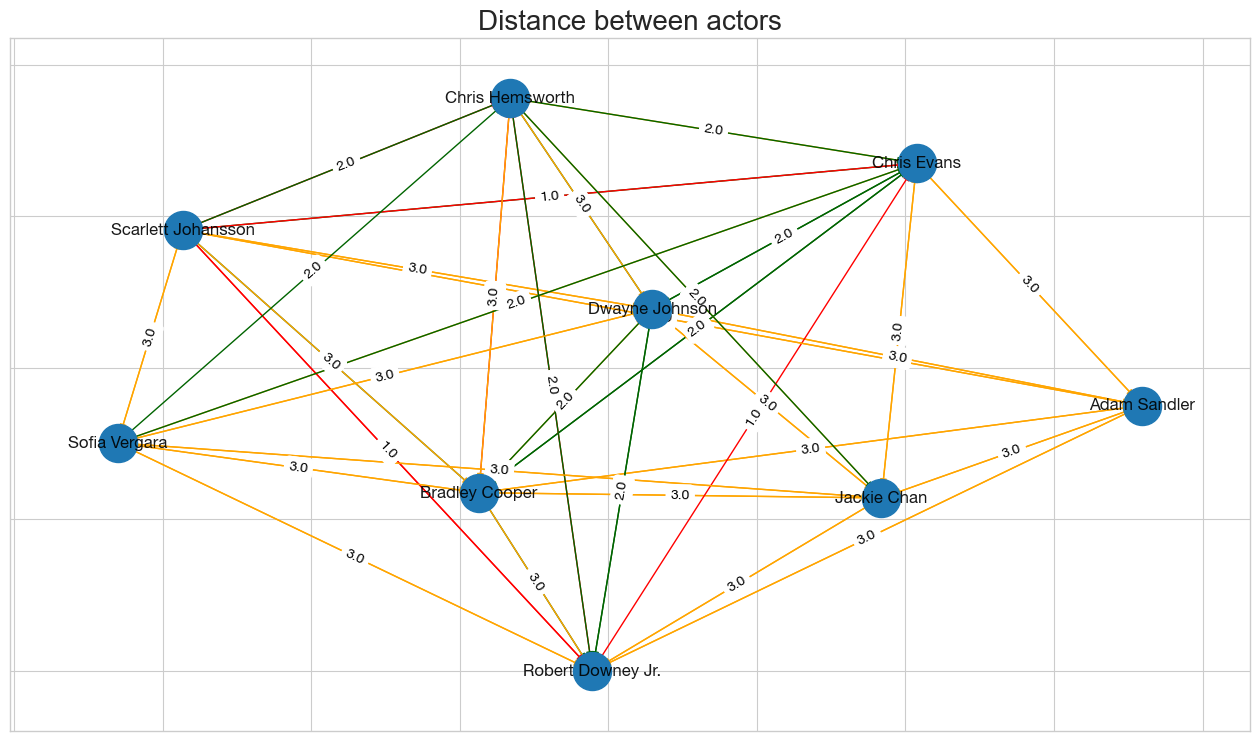

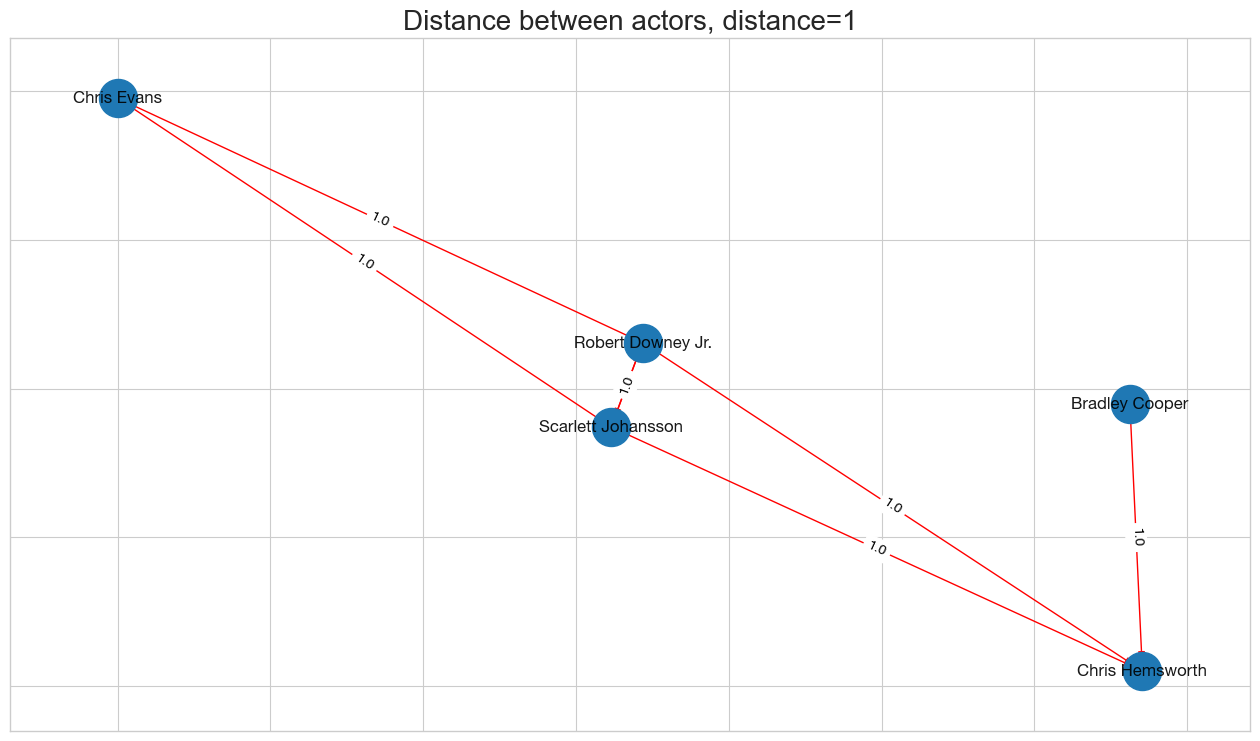

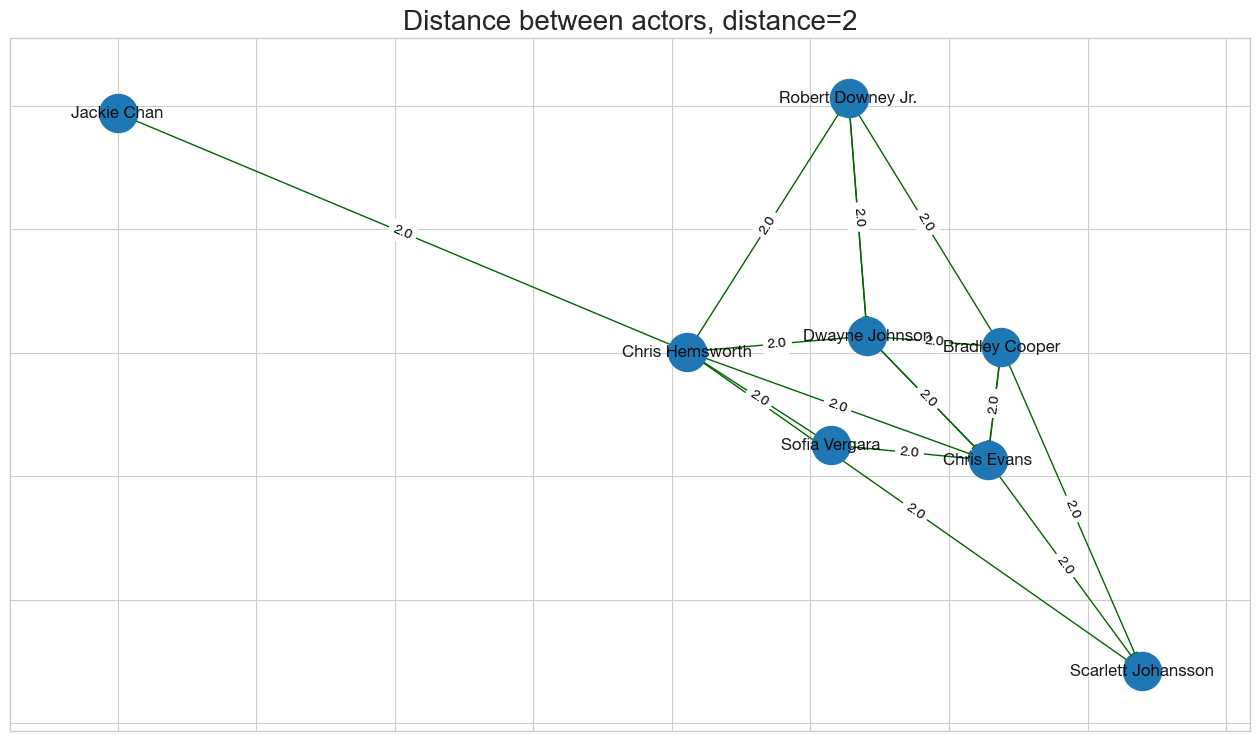

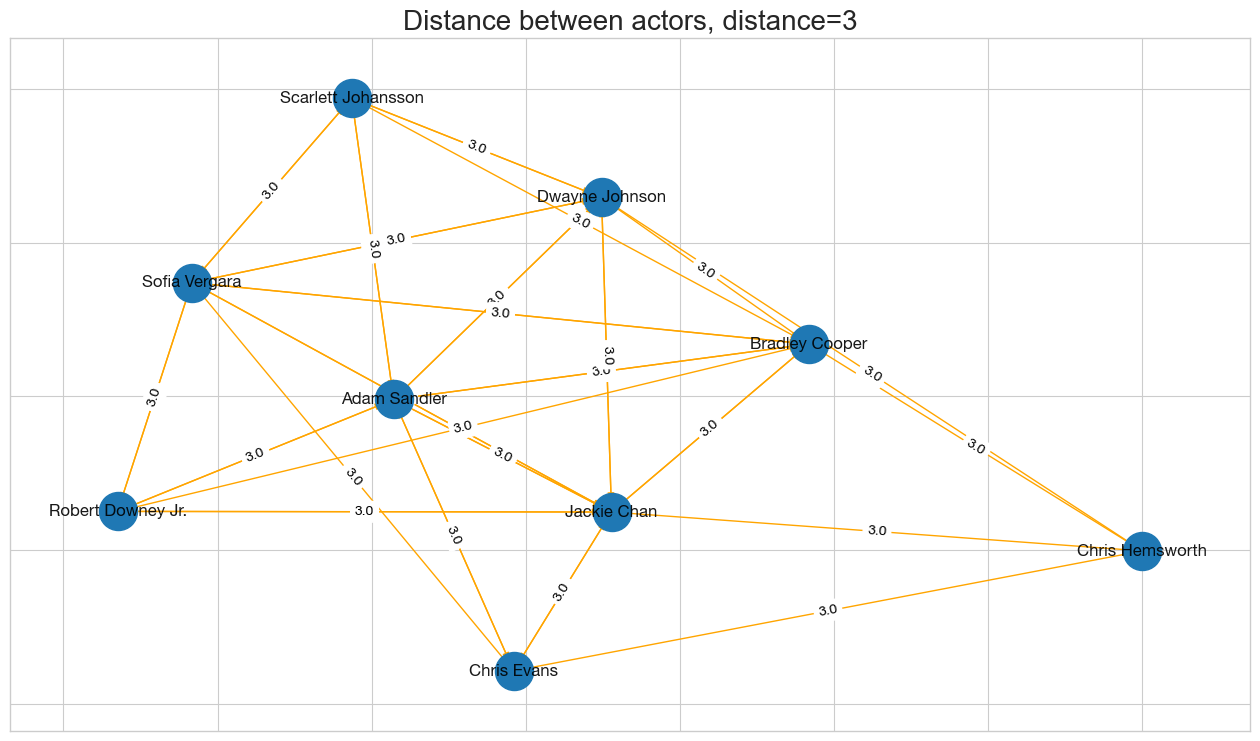

In [13]:
# plotting all the graphs
for i in range(4):
    plot_graphs('./distance.csv', i)

# Descriptions

In [27]:
def get_movie_descriptions_by_actor_soup(actor_page_soup: BeautifulSoup) -> list[str]:
    """
    Returns a movie description for each movie the actor has been in
    params:
        actor_page_soup: BeautifulSoup object, the actor page soup
    returns:
        descriptions: list[str], a list of movie descriptions
    """
    user_agent = {'User-agent': 'Mozilla 5.0'}
    descriptions = []

    movies = get_movies_by_actor_soup(actor_page_soup)

    for name, url in movies:
        url = url.replace('/fullcredits', '')
        response = requests.get(url, headers=user_agent)
        soup = BeautifulSoup(response.text)
        desc = soup.find('span', {'data-testid': 'plot-xl', 'role': 'presentation'})
        if desc:
            descriptions.append(desc.text.strip())
    return descriptions

In [18]:
def save_descriptions(path:str, actors_links:dict) -> None:
    """
    This function takes a path to a csv file and a dictionary of actors and their urls and saves the descriptions of the actors films to the respective files.
    params:
        path: str, path to the csv file folder
        actors_links: dict, keys are actors names, values are imdb pages urls
    returns:
        None
    """
    if not os.path.exists(path):
        os.makedirs(path)
    
    if len(os.listdir(path)) >= len(actors_links):
        print(f'Descriptions already exist. Directory snapshot: \n{os.listdir(path)}')
        return None

    # main function logic
    actor_soups = {name: prep_actor_soup(url) for name, url in actors_links.items()}

    # write descritions to the respective actor files
    for name, soup in actor_soups.items():
        with open(f'./{path}/{name}.txt', 'w') as f:
            for d in get_movie_descriptions_by_actor_soup(soup):
                f.write(d + '\n')

In [21]:
# saving movie descriptions for each actor
save_descriptions('./descriptions', actors_links)

Descriptions already exist. Directory snapshot: 
['Adam Sandler.txt', '.DS_Store', 'Dwayne Johnson.txt', 'Bradley Cooper.txt', 'Scarlett Johansson.txt', 'Chris Hemsworth.txt', 'Robert Downey Jr..txt', 'Jackie Chan.txt', 'Chris Evans.txt', 'Sofia Vergara.txt', 'Akshay Kumar.txt']


# Wordcloud

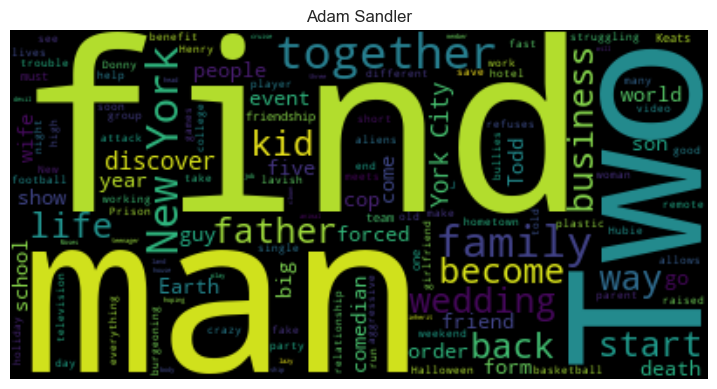

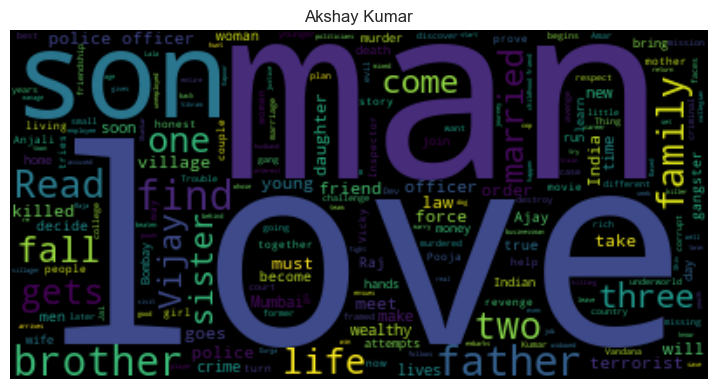

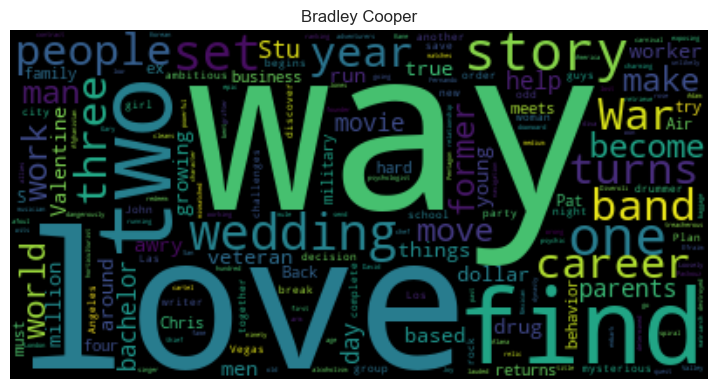

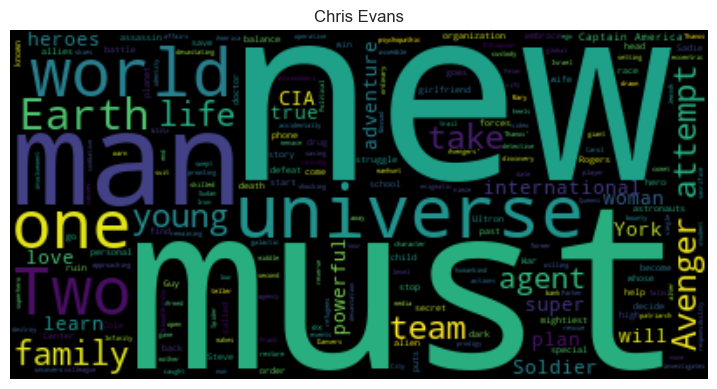

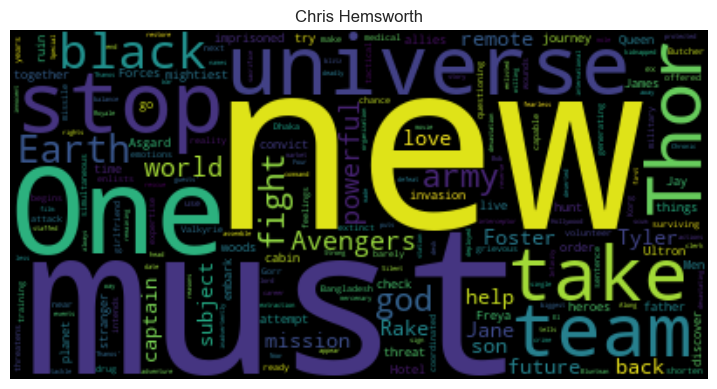

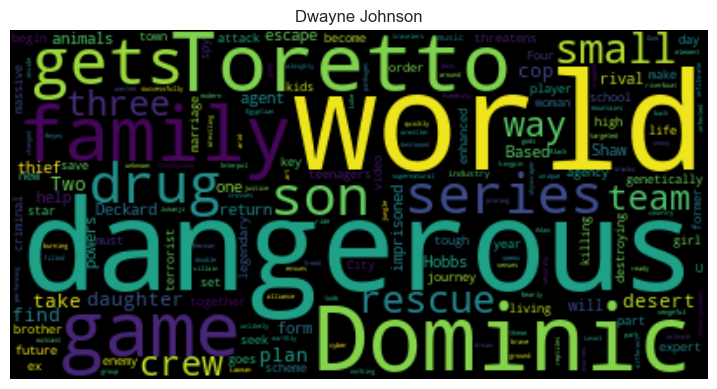

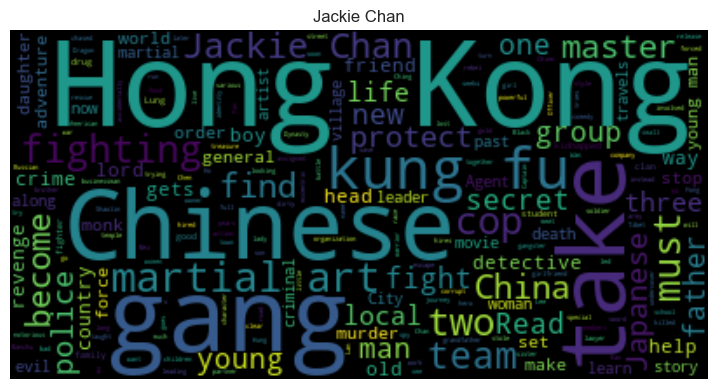

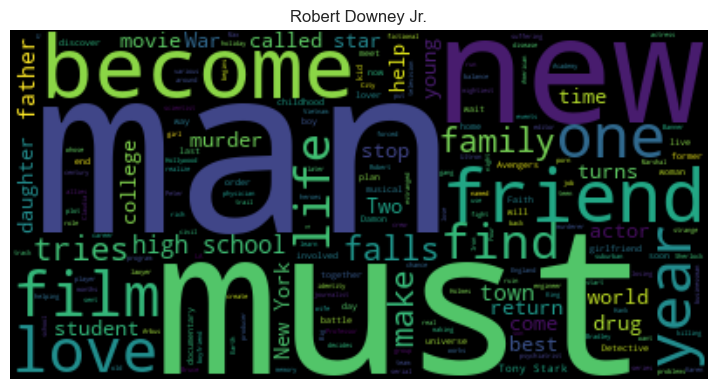

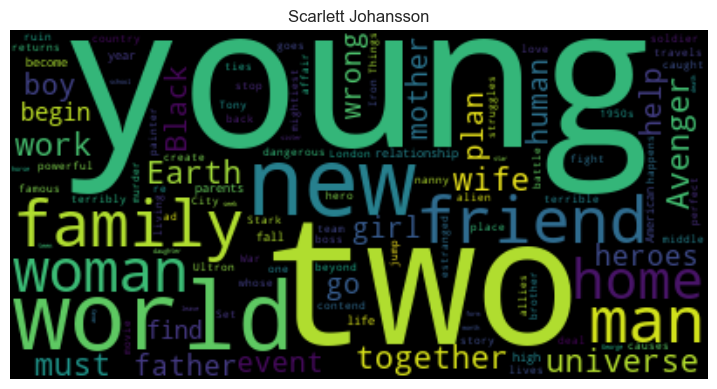

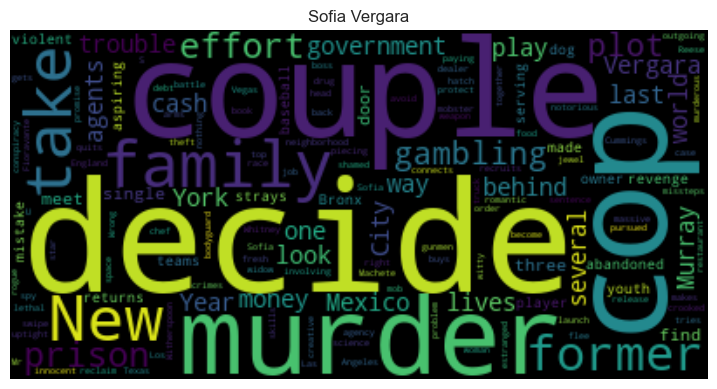

In [20]:
for actor_name in actors_links.keys():
    with open(f'./descriptions/{actor_name}.txt', 'r') as f:
        descriptions = f.read()

        plt.figure(figsize=(9, 6))
        wc = WordCloud(stopwords=STOPWORDS).generate(descriptions)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(actor_name)
        plt.axis('off')
        plt.show()